# CAFE: Context-Aware Fidelity Estimation Framework (by Google)

In [1]:
from __future__ import annotations
import os
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.primitives import BaseSamplerV2

from itertools import product
from qiskit_experiments.library.tomography.basis import (
    PauliPreparationBasis,
)

from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator

# from utils import create_circuit_from_own_unitaries

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

from q_env_config import (
    q_env_config as gate_q_env_config,
)

from rl_qoc import QuantumEnvironment

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Circuit context
Circuit context


/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/q_env_config.py:106: UserWarning: No backend was provided, State vector simulation will be used
  warnings.warn("No backend was provided, State vector simulation will be used")


In [2]:
q_env = QuantumEnvironment(gate_q_env_config)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/helper_functions.py:1721: UserWarning: No Backend was provided, using default values for dt, coupling_map, basis_gates and instruction_durations
  warnings.warn(
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/quantumenvironment.py:1079: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]


n_reps: 1
Checking reward to adjust C Factor...
fidelity access False
Starting simulation benchmark...
Avg gate fidelity: 0.2531798320435195
Finished simulation benchmark
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'XI', 'XY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
Finished Estimator job


In [3]:
n_qubits = 2
n_actions = 7

In [4]:
def append_param_target_gate(qc: QuantumCircuit, params: ParameterVector):
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        0,
    )
    qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        1,
    )
    qc.rzx(optimal_params[6] + params[6], 0, 1)

In [5]:
input_circuits = [
    PauliPreparationBasis().circuit(s) for s in product(range(4), repeat=n_qubits)
]

In [6]:
n_reps = 2
params = np.zeros(n_actions)
run_circs, ref_circs = [], []


def append_ideal_cx(qc: QuantumCircuit):
    qc.cx(0, 1)

In [7]:
from typing import Callable
from qiskit.circuit import QuantumCircuit, Gate


def substitute_target_gate(
    circuit: QuantumCircuit,
    target_gate: Gate,
    parametrized_circuit_func: Callable,
    params: ParameterVector,
    **kwargs
):
    """
    Substitute a target gate in a circuit with a parametrized version of the gate.
    """
    qc = QuantumCircuit(*circuit.qregs, *circuit.cregs)

    for instruction in circuit.data:
        if instruction.operation != target_gate:
            qc.append(instruction)
        else:
            parametrized_circuit_func(qc, params, qc.qregs[0], **kwargs)
    return qc

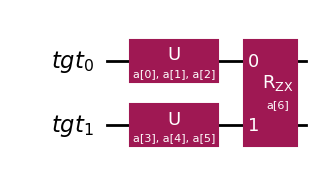

In [8]:
q_env.circuit_truncations[0].decompose().draw("mpl")

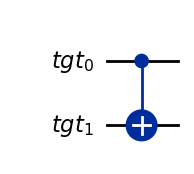

In [9]:
q_env.baseline_truncations[0].draw("mpl")

In [10]:
q_env.n_qubits

2

In [28]:
from gymnasium.spaces import Box
import cma
from qiskit.quantum_info.operators.measures import state_fidelity
from qiskit.quantum_info.states import Statevector

In [12]:
def bounds_from_action_space(action_space: Box):
    """
    Convert the action space of the agent to bounds for the optimizer
    """
    return [(low, high) for low, high in zip(action_space.low, action_space.high)]


class CAFE:
    def __init__(self, q_env: QuantumEnvironment, n_reps: int = 3):
        self.q_env = q_env
        self.n_reps: int = n_reps
        self.circuits_run, self.circuits_ref = self.get_cafe_circuits()
        self.fidelities = []

    def get_cafe_circuits(self):

        circuits_run, circuits_ref = [], []
        circuit_run = self.q_env.circuit_truncations[0]
        circuit_ref = self.q_env.baseline_truncations[0]
        n_qubits = q_env.n_qubits

        input_circuits = input_circuits = [
            PauliPreparationBasis().circuit(s)
            for s in product(range(4), repeat=n_qubits)
        ]

        for input_circ in input_circuits:

            run_qc = QuantumCircuit(n_qubits)  # Circuit with the custom target gate
            ref_qc = QuantumCircuit(
                n_qubits
            )  # Circuit with the ideal gate for reference

            # Bind input states to the circuits
            for qc in [run_qc, ref_qc]:
                qc.compose(input_circ, inplace=True)
                qc.barrier()

            # Add the custom target gate to the run circuit n_reps times
            for qc, context in zip([run_qc, ref_qc], [circuit_run, circuit_ref]):
                for _ in range(1, self.n_reps + 1):
                    qc.compose(context, inplace=True)
                qc.barrier()
            run_qc = substitute_target_gate(
                ref_qc,
                self.q_env.target.gate,
                self.q_env.parametrized_circuit_func,
                q_env.parameters[0],
                **q_env._func_args
            )

            reverse_unitary = Operator(ref_qc).adjoint().to_instruction()
            reverse_unitary_qc = QuantumCircuit(n_qubits)
            reverse_unitary_qc.unitary(
                reverse_unitary,
                reverse_unitary_qc.qubits,
                label="reverse circuit unitary",
            )
            reverse_unitary = transpile(
                reverse_unitary_qc, self.q_env.backend, optimization_level=3
            )  # Try to get the smallest possible circuit for the reverse unitary

            for qc, context in zip([run_qc, ref_qc], [circuit_run, circuit_ref]):
                qc = transpile(qc, self.q_env.backend, optimization_level=0)

            # Add the inverse unitary to the circuits
            for qc in [run_qc, ref_qc]:
                qc.compose(reverse_unitary_qc, inplace=True)
                # qc.unitary(reverse_unitary, qc.qubits, label="reverse circuit unitary")
                qc.measure_all()

            circuits_run.append(run_qc)
            circuits_ref.append(ref_qc)

        return circuits_run, circuits_ref

    def run_cafe_circuits(self, parameter_values):
        sampler = self.q_env.sampler
        if isinstance(sampler, BaseSamplerV2):
            pubs = []
            for qc in self.circuits_run:
                pubs.append((qc, parameter_values))
            results = sampler.run(pubs, shots=self.q_env.n_shots).result()
            counts = [result.data.meas.get_counts() for result in results]
            for count in counts:
                for key in [
                    bin(i)[2:].zfill(self.q_env.n_qubits)
                    for i in range(2**self.q_env.n_qubits)
                ]:
                    if key not in count.keys():
                        count[key] = 0
            fidelity = np.mean(
                [
                    count["0" * self.q_env.n_qubits] / self.q_env.n_shots
                    for count in counts
                ]
            )

        else:
            results = sampler.run(
                self.circuits_run,
                [parameter_values] * len(self.circuits_run),
                shots=self.q_env.n_shots,
            ).result()
            counts = [results.quasi_dists[i] for i in range(len(self.circuits_run))]

            # Count the number of dictionaries where 0 is a key
            # No matter the number of qubits, the zero state will always be "0" since the keys represent the sum over all qubits (so, so state 011 would be mapped to sum(011)=2; 000 to 0; etc.)
            zero_state_key = int(0)
            values_for_key_0 = [
                count[zero_state_key] for count in counts if zero_state_key in count
            ]
            # Calculate the mean value for key 0
            fidelity = sum(values_for_key_0) / len(counts) if values_for_key_0 else 0.0

            return fidelity

    def optimize_CMA(self, initial_params):
        """
        Optimize the parameter values for the circuit to maximize the fidelity using CMA-ES optimizer.

        Parameters:
        initial_params (list or np.array): Initial guess for the parameters.
        """

        # Define the objective function
        def objective_function(params):
            return 1 - self.run_cafe_circuits(params)

        # Run the optimizer
        es = cma.CMAEvolutionStrategy(
            initial_params,
            0.5,
            {
                "maxiter": 1000,
                "tolx": 1e-6,
                "bounds": [-np.pi, np.pi],
            },
        )
        es.optimize(objective_function)

        # Get the best parameters
        optimal_params = es.result.xbest
        minimized_value = es.result.fbest

        return optimal_params, minimized_value

In [13]:
q_env.n_shots = 1024

In [14]:
cafe = CAFE(q_env)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [15]:
fidelity = cafe.run_cafe_circuits(np.ones(n_actions))  # np.ones(n_actions)
fidelity

0.447998046875

In [16]:
optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])

fidelity = cafe.run_cafe_circuits(optimal_params)  # np.ones(n_actions)
fidelity

1.0

In [17]:
def perturb_array(arr, perturbation_scale=0.01):
    """
    Slightly change the values of a given array by adding small random perturbations.

    Parameters:
    arr (numpy.ndarray): The input array to be perturbed.
    perturbation_scale (float): The scale of the perturbations (default is 0.01).

    Returns:
    numpy.ndarray: The perturbed array.
    """
    # Generate random perturbations with the same shape as the input array
    perturbations = np.random.normal(loc=0.0, scale=perturbation_scale, size=arr.shape)

    # Add the perturbations to the input array
    perturbed_arr = arr + perturbations
    perturbed_arr = np.clip(perturbed_arr, -np.pi, np.pi)

    return perturbed_arr

In [18]:
perturbed_params = perturb_array(optimal_params, perturbation_scale=0.2)
perturbed_params - optimal_params

array([-0.05426878,  0.01533891, -0.11960266, -0.33510985,  0.06489833,
        0.01579421,  0.11488549])

In [20]:
optimal_actions_cma, infidelity = cafe.optimize_CMA(np.zeros(n_actions))
print("Final Fideltiy CMA:", 1.0 - infidelity)
optimal_actions_cma

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=112060, Thu May 30 17:58:46 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.843139648437500e-01 1.0e+00 4.36e-01  4e-01  4e-01 0:00.1
    2     18 4.954223632812500e-01 1.2e+00 4.60e-01  4e-01  5e-01 0:00.2
    3     27 5.453491210937500e-01 1.4e+00 4.60e-01  4e-01  5e-01 0:00.3
   33    297 2.441406250000000e-03 4.3e+00 5.80e-02  3e-02  6e-02 0:03.4
   69    621 0.000000000000000e+00 9.0e+00 5.74e-03  1e-03  7e-03 0:07.5
  100    900 0.000000000000000e+00 1.1e+01 4.98e-03  1e-03  4e-03 0:11.1
  107    963 0.000000000000000e+00 1.1e+01 4.48e-03  8e-04  4e-03 0:11.9
Final Fideltiy CMA: 1.0


array([-1.08943094e-04, -2.01211575e-01, -3.20045915e-01, -5.23369732e-01,
       -1.56292237e+00,  1.56080821e+00,  5.23541734e-01])

In [21]:
optimal_actions_cma - optimal_params

array([-1.08943094e-04, -2.01211575e-01, -1.89084224e+00, -2.09416606e+00,
        7.87395376e-03, -9.98811771e-03,  2.09433806e+00])

In [29]:
def get_param_circ(n_reps: int, params: np.ndarray):
    parametrized_qc = QuantumCircuit(2)
    optimal_params = np.pi * np.zeros(len(params))

    for _ in range(n_reps):
        parametrized_qc.u(
            optimal_params[0] + params[0],
            optimal_params[1] + params[1],
            optimal_params[2] + params[2],
            0,
        )
        parametrized_qc.u(
            optimal_params[3] + params[3],
            optimal_params[4] + params[4],
            optimal_params[5] + params[5],
            1,
        )
        parametrized_qc.rzx(optimal_params[6] + params[6], 0, 1)
    # parametrized_qc.save_superop()
    parametrized_qc.save_density_matrix()
    return parametrized_qc


def get_ideal_circ(n_reps: int):
    ideal_qc = QuantumCircuit(2)
    for _ in range(n_reps):
        ideal_qc.cx(0, 1)
    return ideal_qc

In [31]:
def fidelity_function(n_reps, params, backend):
    input_circuits = [
        PauliPreparationBasis().circuit(s) for s in product(range(4), repeat=2)
    ]
    avg_gate_fid = []
    for input_circ in input_circuits:
        ideal_circ = get_ideal_circ(n_reps).compose(input_circ, front=True)
        ideal_circ = transpile(ideal_circ, backend, optimization_level=0)

        noisy_circ = get_param_circ(n_reps, params).compose(input_circ, front=True)
        noisy_circ = transpile(noisy_circ, backend, optimization_level=0)

        process_results = backend.run(noisy_circ).result()
        q_process_list = [
            # process_results.data(0)["superop"],
            process_results.data(0)["density_matrix"],
        ]
        avg_fidelity = np.mean(
            [
                # average_gate_fidelity(q_process, Operator(ideal_circ))
                # for q_process in q_process_list
                state_fidelity(q_process, Statevector(ideal_circ))
                for q_process in q_process_list
            ]
        )
        avg_gate_fid.append(avg_fidelity)

    return -np.mean(avg_fidelity)

In [32]:
backend = AerSimulator()
n_reps = cafe.n_reps
params = optimal_actions_cma

fidelity = -fidelity_function(n_reps, params, backend)
fidelity

0.9999761023877458

# ORBIT

In [ ]:
from gate_level.standard.orbit import ORBIT

In [ ]:
orbit = ORBIT(rb_length=40, num_sequences=3, q_env=q_env)

In [ ]:
orbit.run_orbit_circuits(np.zeros(n_actions))

In [ ]:
orbit_optimal_params, orbit_infidelity, cma_result = orbit.optimize_CMA(
    np.zeros(n_actions)
)

In [ ]:
optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
orbit_optimal_params - optimal_params

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(orbit.fidelities)